In [56]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from itertools import combinations
import random
from collections import deque

In [57]:
data = pd.read_csv('mushrooms.csv').dropna()

In [58]:
y = data['class'].values
n = int(np.sqrt(data.shape[1]-1))
x = data.drop('class', axis=1).sample(n=n, axis=1).values

In [59]:

class CATTrees:
  def __init__(self, max_depth):
    self.max_depth = max_depth

  def fit(self, x, y):
    self.x, self.y = x, y
    self.classes = list(set(y))
    self.build_tree(x, y, 0)
    return self

  def predict(self, x):
    return np.array([self.root.classify(i) for i in x])

  def predict_proba(self, x):
    return np.array([self.root.predict_proba(i) for i in x])

  def get_splits(self, elements, k):
    def _combinations(elements, k):
      if k == 1:
          return [[elements]]
      partitions = []

      for i in range(1, len(elements)):
          for comb in combinations(elements, i):
              rest = list(set(elements) - set(comb))
              for partition in _combinations(rest, k - 1):
                  partitions.append([list(comb)] + partition)

      return partitions
    return  set(frozenset(frozenset(i) for i in part) for part in _combinations(elements, k))

  def split_data(self, x, y, feature, split_ex):
    indexes = [list() for _ in range(len(split_ex))]

    for i, val in enumerate(x[:, feature]):
      for j, ex in enumerate(list(split_ex)):
        if val in ex:
          indexes[j].append(i)
    return [(x[np.array(index)], y[np.array(index)]) for index in indexes]

  @staticmethod
  def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    return entropy(counts, base=2)

  def count_ig(self, y, splited):
    entropy, n = self.entropy(y), len(y)
    for x_i, y_i in splited:
      entropy -= len(y_i) / n * self.entropy(y_i)
    return entropy

  def get_random_split(self, elements):
      k = random.randint(2, len(elements))

      elements = list(elements)
      random.shuffle(elements)

      subsets = [[] for _ in range(k)]

      for i, elem in enumerate(elements):
          subsets[i % k].append(elem)

      subsets = [set(subset) for subset in subsets]

      return subsets

  def find_best_split(self, x, y):
    best_ig, best_feature, best_split = -1, -1, -1
    for feature in range(x.shape[1]):
      feature_set = set(x[:, feature])
      if len(feature_set) == 1:
        continue
      for _ in range(10):
        split_ex = self.get_random_split(feature_set)
        splited = self.split_data(x, y, feature, split_ex)
        ig = self.count_ig(y, splited)
        if best_ig < ig:
          best_ig, best_feature, best_split = ig, feature, split_ex
    return best_ig, best_feature, list(best_split)

  def build_tree(self, x, y, depth):
    self.root = self.Leaf(x, y, 0, None)
    deq = deque([self.root])
    while deq:
      leaf = deq.pop()
      if leaf.depth == self.max_depth or leaf.entropy == 0:
        continue
      ig, feature, split = self.find_best_split(leaf.x, leaf.y)
      splited_data = self.split_data(leaf.x, leaf.y, feature, split)
      node = self.Node(splited_data, leaf.depth, feature, split)

      if leaf.parent is not None:
        leaf.parent.children[leaf.parent.get_link(leaf)] = node
      else:
        self.root = node
      deq.extend(node.children.values())

  class Node:
    def __init__(self, splited_data, depth, feature, split_ex):
      self.depth, self.split, self.feature = depth, split_ex, feature
      self.children = dict()
      for spl_data, spl_ex in zip(splited_data, split_ex):
        x, y = spl_data
        self.children[frozenset(spl_ex)] = CATTrees.Leaf(x, y, depth + 1, self)

    def get_link(self, leaf):
      for cond in self.children:
        if self.children[cond] is leaf:
          return cond
      return None

    def classify(self, x):
      for child in self.children:
        if x[self.feature] in child:
          return self.children[child].classify(x)
      return None

    def predict_proba(self, x):
      for child in self.children:
        if x[self.feature] in child:
          return self.children[child].predict_proba(x)
      return None

  class Leaf:
    def __init__(self,x, y, depth, parent):
      self.x, self.y, self.depth, self.parent = x, y, depth, parent
      self.entropy = CATTrees.entropy(y)
      self.out, self.counts = np.unique(y, return_counts=True)

    def classify(self, x):
      return self.out[0]

    def predict_proba(self, x):
      dct = {c: n for c, n in zip(self.out, self.counts)}
      return [dct.get(c, 0) for c in {'e', 'p'}] / self.counts.sum()

  def cme(self, y_true, y_pred, pos_neg):
    pos, neg = pos_neg

    TP, TN, FP, FN = 0, 0, 0, 0

    for true, pred in zip(y_true, y_pred):
        if true == pred == pos:
            TP += 1
        elif true == pred == neg:
            TN += 1
        elif true == neg and pred == pos:
            FP += 1
        elif true == pos and pred == neg:
            FN += 1

    return TP, TN, FP, FN

  def accuracy(self, x, y, pos_neg=list(set(y))):
    TP, TN, FP, FN = self.cme(y, self.predict(x), pos_neg)
    total = TP + TN + FP + FN
    return (TP + TN) / total

  def precision(self, x, y, pos_neg=list(set(y))):
    TP, TN, FP, FN = self.cme(y, self.predict(x), pos_neg)
    return TP / (TP + FP)

  def recall(self, x, y, pos_neg=list(set(y))):
    TP, TN, FP, FN = self.cme(y, self.predict(x), pos_neg)
    return TP / (TP + FN)



In [60]:
tree = CATTrees(3)
tree.fit(x, y)

In [61]:
print(tree.accuracy(x, y))
print(tree.recall(x, y))
print(tree.precision(x, y))

0.8355489906450024
1.0
0.759018759018759


In [62]:
y_prob = tree.predict_proba(x)[:, 1]

In [63]:
y_true = np.array([yi == 'e' for yi in y]).astype(int)

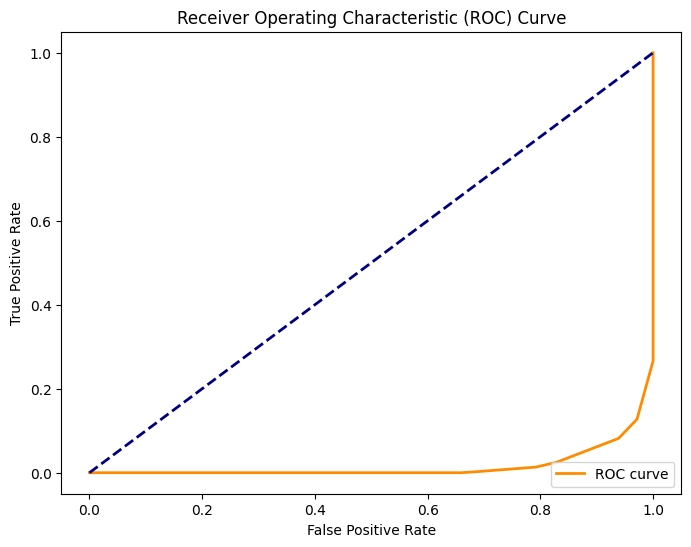

/var/folders/pl/zhkjndkn2k169_3t63dgk06m0000gn/T/ipykernel_6263/1638659309.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_list, fpr_list)


In [64]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    return TP, TN, FP, FN

def plot_roc_curve(y_true, y_prob):
    thresholds = np.linspace(0, 1, 101)

    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        TP, TN, FP, FN = calculate_metrics(y_true, y_prob, threshold)
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_list + [0],tpr_list+[0], color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    auc = np.trapz(tpr_list, fpr_list)
    return auc

auc = plot_roc_curve(y_true, y_prob)


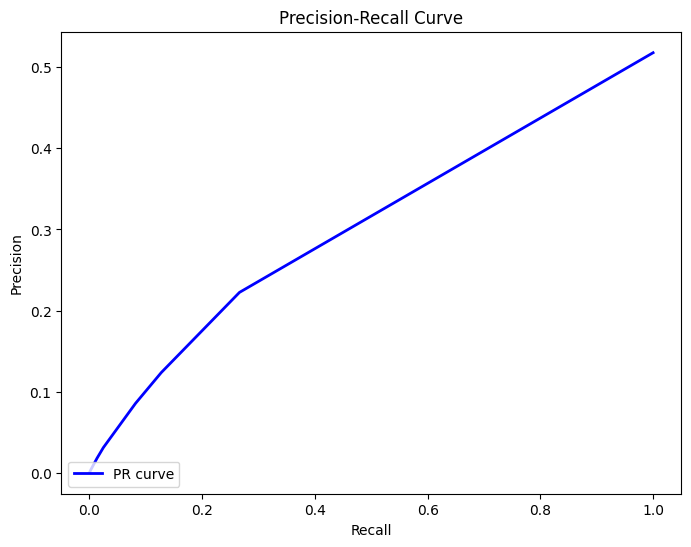

AUC-PR: -0.30


/var/folders/pl/zhkjndkn2k169_3t63dgk06m0000gn/T/ipykernel_6263/4088845291.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision_list, recall_list)


In [65]:

import numpy as np
import matplotlib.pyplot as plt

def calculate_precision_recall(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall

def plot_pr_curve(y_true, y_prob):
    thresholds = np.linspace(0, 1, 101)

    precision_list = []
    recall_list = []

    for threshold in thresholds:
        precision, recall = calculate_precision_recall(y_true, y_prob, threshold)
        precision_list.append(precision)
        recall_list.append(recall)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_list, precision_list, color='blue', lw=2, label='PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    auc_pr = np.trapz(precision_list, recall_list)
    print(f"AUC-PR: {auc_pr:.2f}")
    return auc_pr

auc_pr = plot_pr_curve(y_true, y_prob)
